In [1]:
#Suppress pycache file
import sys
sys.dont_write_bytecode = True
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
import json
from scipy import stats
from scipy.stats import linregress
from pprint import pprint


# Import the GeoAPIfy API key
from api_keys import GEO_API_KEY
print(GEO_API_KEY)

# Import citipy to determine the cities based on latitude and longitude
# from citipy import citipy

141b8691f629447f822359b7dafbbb82


In [2]:
# Load the CSV file created in Part 1 into a Pandas DataFrame
nba_data_df = pd.read_csv("./Resources/nba_data_2020_2022_seasons.csv")
nba_team_location_df = pd.read_csv("./Resources/team_locations.csv")

# Display sample data
nba_data_df.head()

,Year,Team,Game,Date,Start (ET),Away game indicator,Opponent,Result,Tm,Opp,W,L,Streak,Notes,Home or Away
0,2022,Chicago Bulls,1,"Wed, Oct 19, 2022",7:30p,@,Miami Heat,W,116,108,1,0,W 1,NaN,Away
1,2022,Chicago Bulls,2,"Fri, Oct 21, 2022",7:00p,@,Washington Wizards,L,100,102,1,1,L 1,NaN,Away
2,2022,Chicago Bulls,3,"Sat, Oct 22, 2022",8:00p,NaN,Cleveland Cavaliers,L,96,128,1,2,L 2,NaN,Home
3,2022,Chicago Bulls,4,"Mon, Oct 24, 2022",8:00p,NaN,Boston Celtics,W,120,102,2,2,W 1,NaN,Home
4,2022,Chicago Bulls,5,"Wed, Oct 26, 2022",8:00p,NaN,Indiana Pacers,W,124,109,3,2,W 2,NaN,Home


In [3]:
#Add column to indicate which team was hosting
nba_data_df['Host Team'] = np.where(nba_data_df['Home or Away'] == 'Home', nba_data_df['Team'], nba_data_df['Opponent'])
#Add host team details (Arena name, location, etc.)
combined_nba_data = pd.merge(nba_data_df, nba_team_location_df, left_on=["Host Team"], right_on=["Team Name"])
#Exclude play-in games
combined_nba_data = combined_nba_data.loc[combined_nba_data['Notes'] != 'Play-In Game']
combined_nba_data.head()


,Year,Team,Game,Date,Start (ET),Away game indicator,Opponent,Result,Tm,Opp,...,L,Streak,Notes,Home or Away,Host Team,Team Name,Arena Name,Arena Location,Seating Capacity,Opening Year
0,2022,Chicago Bulls,1,"Wed, Oct 19, 2022",7:30p,@,Miami Heat,W,116,108,...,0,W 1,NaN,Away,Miami Heat,Miami Heat,American Airlines Arena,"Miami, Florida","19,600",1999
1,2022,Chicago Bulls,30,"Tue, Dec 20, 2022",7:30p,@,Miami Heat,W,113,103,...,18,W 1,NaN,Away,Miami Heat,Miami Heat,American Airlines Arena,"Miami, Florida","19,600",1999
3,2021,Chicago Bulls,27,"Sat, Dec 11, 2021",8:00p,@,Miami Heat,L,92,118,...,10,L 2,NaN,Away,Miami Heat,Miami Heat,American Airlines Arena,"Miami, Florida","19,600",1999
4,2021,Chicago Bulls,62,"Mon, Feb 28, 2022",7:30p,@,Miami Heat,L,99,112,...,23,L 2,NaN,Away,Miami Heat,Miami Heat,American Airlines Arena,"Miami, Florida","19,600",1999
5,2020,Chicago Bulls,60,"Sat, Apr 24, 2021",8:00p,@,Miami Heat,L,101,106,...,35,L 1,NaN,Away,Miami Heat,Miami Heat,American Airlines Arena,"Miami, Florida","19,600",1999


In [4]:
#Define columns of interest
columns_of_interest = ['Year', 'Team', 'Game', 'Date', 'Opponent', 'Result', 'Tm', 'Opp', 'Home or Away', 'Host Team', 'Arena Name', 'Arena Location']

In [5]:
#Create new dataframe with only columns of interest
final_nba_data = combined_nba_data[(columns_of_interest)]
#Exclude play-in games to make game count consistent between both teams
#final_nba_data = final_nba_data.loc[final_nba_data['Game'] <= 82]
final_nba_data.sort_values(by=['Year', 'Team', 'Game']).reset_index(drop=True)

,Year,Team,Game,Date,Opponent,Result,Tm,Opp,Home or Away,Host Team,Arena Name,Arena Location
0,2020,Chicago Bulls,1,"Wed, Dec 23, 2020",Atlanta Hawks,L,104,124,Home,Chicago Bulls,United Center,"Chicago, Illinois"
1,2020,Chicago Bulls,2,"Sat, Dec 26, 2020",Indiana Pacers,L,106,125,Home,Chicago Bulls,United Center,"Chicago, Illinois"
2,2020,Chicago Bulls,3,"Sun, Dec 27, 2020",Golden State Warriors,L,128,129,Home,Chicago Bulls,United Center,"Chicago, Illinois"
3,2020,Chicago Bulls,4,"Tue, Dec 29, 2020",Washington Wizards,W,115,107,Away,Washington Wizards,Capital One Arena,"Washington, D.C."
4,2020,Chicago Bulls,5,"Thu, Dec 31, 2020",Washington Wizards,W,133,130,Away,Washington Wizards,Capital One Arena,"Washington, D.C."
...,...,...,...,...,...,...,...,...,...,...,...,...
467,2022,Los Angeles Lakers,78,"Sun, Apr 2, 2023",Houston Rockets,W,134,109,Away,Houston Rockets,Toyota Center,"Houston, Texas"
468,2022,Los Angeles Lakers,79,"Tue, Apr 4, 2023",Utah Jazz,W,135,133,Away,Utah Jazz,Vivint Smart Home Arena,"Salt Lake City, Utah"
469,2022,Los Angeles Lakers,80,"Wed, Apr 5, 2023",Los Angeles Clippers,L,118,125,Away,Los Angeles Clippers,Staples Center,"Los Angeles, California"
470,2022,Los Angeles Lakers,81,"Fri, Apr 7, 2023",Phoenix Suns,W,121,107,Home,Los Angeles Lakers,Staples Center,"Los Angeles, California"


In [6]:
chicago_data = final_nba_data.loc[(final_nba_data["Team"] == 'Chicago Bulls')].sort_values(by=['Year', 'Team', 'Game']).reset_index(drop=True)
chicago_data

,Year,Team,Game,Date,Opponent,Result,Tm,Opp,Home or Away,Host Team,Arena Name,Arena Location
0,2020,Chicago Bulls,1,"Wed, Dec 23, 2020",Atlanta Hawks,L,104,124,Home,Chicago Bulls,United Center,"Chicago, Illinois"
1,2020,Chicago Bulls,2,"Sat, Dec 26, 2020",Indiana Pacers,L,106,125,Home,Chicago Bulls,United Center,"Chicago, Illinois"
2,2020,Chicago Bulls,3,"Sun, Dec 27, 2020",Golden State Warriors,L,128,129,Home,Chicago Bulls,United Center,"Chicago, Illinois"
3,2020,Chicago Bulls,4,"Tue, Dec 29, 2020",Washington Wizards,W,115,107,Away,Washington Wizards,Capital One Arena,"Washington, D.C."
4,2020,Chicago Bulls,5,"Thu, Dec 31, 2020",Washington Wizards,W,133,130,Away,Washington Wizards,Capital One Arena,"Washington, D.C."
...,...,...,...,...,...,...,...,...,...,...,...,...
231,2022,Chicago Bulls,78,"Sun, Apr 2, 2023",Memphis Grizzlies,W,128,107,Home,Chicago Bulls,United Center,"Chicago, Illinois"
232,2022,Chicago Bulls,79,"Tue, Apr 4, 2023",Atlanta Hawks,L,105,123,Home,Chicago Bulls,United Center,"Chicago, Illinois"
233,2022,Chicago Bulls,80,"Wed, Apr 5, 2023",Milwaukee Bucks,L,92,105,Away,Milwaukee Bucks,Fiserv Forum,"Milwaukee, Wisconsin"
234,2022,Chicago Bulls,81,"Fri, Apr 7, 2023",Dallas Mavericks,W,115,112,Away,Dallas Mavericks,American Airlines Center,"Dallas, Texas"


In [7]:
chicago_2022_data = chicago_data.loc[chicago_data['Year'] == 2022].sort_values(by=['Year', 'Team', 'Game']).reset_index(drop=True)
chicago_2022_data

,Year,Team,Game,Date,Opponent,Result,Tm,Opp,Home or Away,Host Team,Arena Name,Arena Location
0,2022,Chicago Bulls,1,"Wed, Oct 19, 2022",Miami Heat,W,116,108,Away,Miami Heat,American Airlines Arena,"Miami, Florida"
1,2022,Chicago Bulls,2,"Fri, Oct 21, 2022",Washington Wizards,L,100,102,Away,Washington Wizards,Capital One Arena,"Washington, D.C."
2,2022,Chicago Bulls,3,"Sat, Oct 22, 2022",Cleveland Cavaliers,L,96,128,Home,Chicago Bulls,United Center,"Chicago, Illinois"
3,2022,Chicago Bulls,4,"Mon, Oct 24, 2022",Boston Celtics,W,120,102,Home,Chicago Bulls,United Center,"Chicago, Illinois"
4,2022,Chicago Bulls,5,"Wed, Oct 26, 2022",Indiana Pacers,W,124,109,Home,Chicago Bulls,United Center,"Chicago, Illinois"
...,...,...,...,...,...,...,...,...,...,...,...,...
77,2022,Chicago Bulls,78,"Sun, Apr 2, 2023",Memphis Grizzlies,W,128,107,Home,Chicago Bulls,United Center,"Chicago, Illinois"
78,2022,Chicago Bulls,79,"Tue, Apr 4, 2023",Atlanta Hawks,L,105,123,Home,Chicago Bulls,United Center,"Chicago, Illinois"
79,2022,Chicago Bulls,80,"Wed, Apr 5, 2023",Milwaukee Bucks,L,92,105,Away,Milwaukee Bucks,Fiserv Forum,"Milwaukee, Wisconsin"
80,2022,Chicago Bulls,81,"Fri, Apr 7, 2023",Dallas Mavericks,W,115,112,Away,Dallas Mavericks,American Airlines Center,"Dallas, Texas"


In [8]:
cities = []

for city in final_nba_data['Arena Location']:
    if city not in cities:
        cities.append(city)

print(cities)

['Miami, Florida', 'Washington, D.C.', 'Chicago, Illinois', 'San Antonio, Texas', 'Brooklyn, New York', 'Boston, Massachusetts', 'Toronto, Ontario', 'New Orleans, Louisiana', 'Milwaukee, Wisconsin', 'Oklahoma City, Oklahoma', 'Salt Lake City, Utah', 'Phoenix, Arizona', 'San Francisco, California', 'Sacramento, California', 'Atlanta, Georgia', 'Minneapolis, Minnesota', 'New York City, New York', 'Cleveland, Ohio', 'Philadelphia, Pennsylvania', 'Detroit, Michigan', 'Indianapolis, Indiana', 'Charlotte, North Carolina', 'Orlando, Florida', 'Memphis, Tennessee', 'Denver, Colorado', 'Houston, Texas', 'Portland, Oregon', 'Los Angeles, California', 'Dallas, Texas']


**Distance Travelled Analysis**

In [9]:
#Create list of cities each team travelled to
chicago_2020_2023_data = final_nba_data.loc[final_nba_data['Team'] == 'Chicago Bulls']
chicago_travelled_cities = []
for city in chicago_2020_2023_data['Arena Location']:
    if city not in chicago_travelled_cities:
        chicago_travelled_cities.append(city)
print(chicago_travelled_cities)
la_2020_2023_data = final_nba_data.loc[final_nba_data['Team'] == 'Los Angeles Lakers']
la_travelled_cities = []
for city in la_2020_2023_data['Arena Location']:
    if city not in la_travelled_cities:
        la_travelled_cities.append(city)
print(la_travelled_cities)

['Miami, Florida', 'Washington, D.C.', 'Chicago, Illinois', 'San Antonio, Texas', 'Brooklyn, New York', 'Boston, Massachusetts', 'Toronto, Ontario', 'New Orleans, Louisiana', 'Milwaukee, Wisconsin', 'Oklahoma City, Oklahoma', 'Salt Lake City, Utah', 'Phoenix, Arizona', 'San Francisco, California', 'Sacramento, California', 'Atlanta, Georgia', 'Minneapolis, Minnesota', 'New York City, New York', 'Cleveland, Ohio', 'Philadelphia, Pennsylvania', 'Detroit, Michigan', 'Indianapolis, Indiana', 'Charlotte, North Carolina', 'Orlando, Florida', 'Memphis, Tennessee', 'Denver, Colorado', 'Houston, Texas', 'Portland, Oregon', 'Los Angeles, California', 'Dallas, Texas']
['Miami, Florida', 'Washington, D.C.', 'Chicago, Illinois', 'San Antonio, Texas', 'Brooklyn, New York', 'Boston, Massachusetts', 'Toronto, Ontario', 'New Orleans, Louisiana', 'Milwaukee, Wisconsin', 'Oklahoma City, Oklahoma', 'Salt Lake City, Utah', 'Phoenix, Arizona', 'San Francisco, California', 'Sacramento, California', 'Atlanta,

In [10]:
#Import geoapify
import requests
def get_coordinates(city_state):
    url = f'https://api.geoapify.com/v1/geocode/search?text={city_state}&apiKey={GEO_API_KEY}'
    response = requests.get(url)
    if response.status_code == 200:
        return response.json()['features'][0]['geometry']['coordinates']
    else:
        print(f"Error geocoding {city_state}: {response.text}")
        return None
#Get coordinates for cities each team travelled to
chicago_travelled_coordinates = [get_coordinates(city) for city in chicago_travelled_cities]
la_travelled_coordinates = [get_coordinates(city) for city in la_travelled_cities]

In [11]:
#Module needed for calculating distance between 2 coordinates
!pip install haversine

In [12]:
from haversine import haversine
#Get home coordinates
chicago_home_location = get_coordinates("Chicago, IL")
la_home_location = get_coordinates("Los Angeles, CA")

In [13]:
#Combine city & state with longitude and latitude
arenas_location = set(chicago_2020_2023_data['Arena Location']) | set(la_2020_2023_data['Arena Location'])
location_coordinates = {arena: get_coordinates(arena) for arena in arenas_location}

In [14]:
#Function for calculating distance between home location and game location
def calculate_distances(home_location, arena_locations):
    distances = []
    for city in arena_locations:
        away_location = location_coordinates[city]
        distance_km = haversine((home_location[1], home_location[0]), (away_location[1], away_location[0]))
        distance_miles = distance_km * 0.621371 
        distances.append(distance_miles)
    return distances

In [15]:
chicago_distances = calculate_distances(chicago_home_location, chicago_2020_2023_data['Arena Location'])
la_distances = calculate_distances(la_home_location, la_2020_2023_data['Arena Location'])

Chicago Bulls R-squared: 0.014908877374926825
Los Angeles Lakers R-squared: 0.0007133604238067606


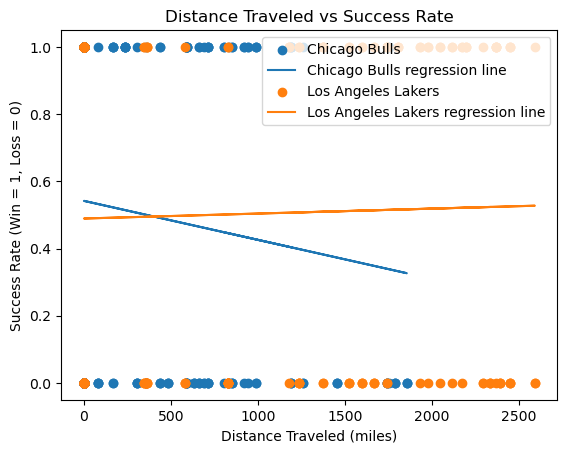

In [16]:
#Success rate based on distance
def plot_distances_vs_success(distances, success_rate, team_name):
    plt.scatter(distances, success_rate, label=team_name)
    slope, intercept, r_value, p_value, std_err = stats.linregress(distances, success_rate)
    plt.plot(distances, intercept + slope * np.array(distances), label=f'{team_name} regression line')
    print(f"{team_name} R-squared: {r_value**2}")

chicago_success_rate = chicago_2020_2023_data['Result'].apply(lambda x: 1 if x == 'W' else 0).values
la_success_rate = la_2020_2023_data['Result'].apply(lambda x: 1 if x == 'W' else 0).values

plot_distances_vs_success(chicago_distances, chicago_success_rate, 'Chicago Bulls')
plot_distances_vs_success(la_distances, la_success_rate, 'Los Angeles Lakers')

plt.xlabel('Distance Traveled (miles)')
plt.ylabel('Success Rate (Win = 1, Loss = 0)')
plt.legend()
plt.title('Distance Traveled vs Success Rate')
plt.show()

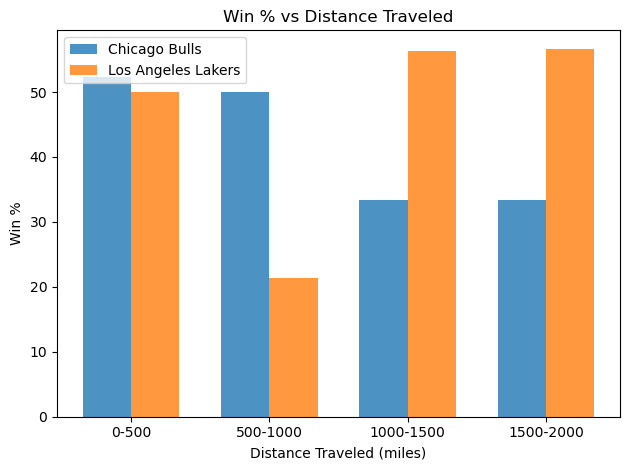

In [17]:
import numpy as np
import matplotlib.pyplot as plt

bins = [0, 500, 1000, 1500, 2000]

def bin_distances(distances):
    return np.digitize(distances, bins)

chicago_distance_bins = bin_distances(chicago_distances)
la_distance_bins = bin_distances(la_distances)

def winning_percentage_for_bins(distance_bins, success_rate):
    percentages = []
    for i in range(1, len(bins)):
        matches_in_bin = np.where(distance_bins == i)
        if len(matches_in_bin[0]) == 0:
            percentages.append(0)
        else:
            percentages.append(np.mean(success_rate[matches_in_bin]))
    return percentages

chicago_percentages = winning_percentage_for_bins(chicago_distance_bins, chicago_success_rate * 100)
la_percentages = winning_percentage_for_bins(la_distance_bins, la_success_rate * 100)

bar_width = 0.35
index = np.arange(len(bins) - 1) 
labels = [f"{bins[i]}-{bins[i+1]}" for i in range(len(bins)-1)]

fig, ax = plt.subplots()
bar1 = ax.bar(index, chicago_percentages, bar_width, label="Chicago Bulls", alpha=0.8)
bar2 = ax.bar(index + bar_width, la_percentages, bar_width, label="Los Angeles Lakers", alpha=0.8)

ax.set_xlabel('Distance Traveled (miles)')
ax.set_ylabel('Win %')
ax.set_title('Win % vs Distance Traveled')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(labels)
ax.legend()
plt.savefig("./outputs/win_percent_vs_distance_traveled.png")
plt.tight_layout()
plt.show()

In [18]:
#Read player stats csv
player_2022_stats = pd.read_csv("./Resources/player_stats_2022.csv")
player_2022_stats

,Year,Team,Player,Rk,G,Date,Age,Tm,Opp,Difference,...,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,GmSc,+/-
0,2022,Chicago Bulls,DeMar DeRozan,1,1.0,10/19/2022,33-073,CHI,MIA,W (+8),...,5,6,9,2,1,1,3,37,34.6,13
1,2022,Chicago Bulls,DeMar DeRozan,2,2.0,10/21/2022,33-075,CHI,WAS,L (-2),...,5,6,6,1,0,3,1,32,23.9,1
2,2022,Chicago Bulls,DeMar DeRozan,3,3.0,10/22/2022,33-076,CHI,CLE,L (-32),...,2,2,1,2,0,0,2,13,10.4,-6
3,2022,Chicago Bulls,DeMar DeRozan,4,4.0,10/24/2022,33-078,CHI,BOS,W (+18),...,5,5,5,1,0,3,1,25,19.7,1
4,2022,Chicago Bulls,DeMar DeRozan,5,5.0,10/26/2022,33-080,CHI,IND,W (+15),...,1,1,6,0,0,3,5,17,9.1,-3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
490,2022,Los Angeles Lakers,De'Angelo Russell,81,68.0,4/2/2023,27-038,LAL,HOU,W (+25),...,3,3,4,0,0,0,0,6,7.3,2
491,2022,Los Angeles Lakers,De'Angelo Russell,82,NaN,4/4/2023,27-040,LAL,UTA,W (+2),...,Inactive,Inactive,Inactive,Inactive,Inactive,Inactive,Inactive,Inactive,Inactive,Inactive
492,2022,Los Angeles Lakers,De'Angelo Russell,83,69.0,4/5/2023,27-041,LAL,LAC,L (-7),...,2,3,7,0,0,1,1,15,12.7,8
493,2022,Los Angeles Lakers,De'Angelo Russell,84,70.0,4/7/2023,27-043,LAL,PHO,W (+14),...,3,3,3,0,0,6,2,24,14,9


In [19]:
nba_2022_data = final_nba_data.loc[final_nba_data['Year'] == 2022]
nba_2022_data.sort_values(by=['Year', 'Team', 'Game']).reset_index(drop=True)

,Year,Team,Game,Date,Opponent,Result,Tm,Opp,Home or Away,Host Team,Arena Name,Arena Location
0,2022,Chicago Bulls,1,"Wed, Oct 19, 2022",Miami Heat,W,116,108,Away,Miami Heat,American Airlines Arena,"Miami, Florida"
1,2022,Chicago Bulls,2,"Fri, Oct 21, 2022",Washington Wizards,L,100,102,Away,Washington Wizards,Capital One Arena,"Washington, D.C."
2,2022,Chicago Bulls,3,"Sat, Oct 22, 2022",Cleveland Cavaliers,L,96,128,Home,Chicago Bulls,United Center,"Chicago, Illinois"
3,2022,Chicago Bulls,4,"Mon, Oct 24, 2022",Boston Celtics,W,120,102,Home,Chicago Bulls,United Center,"Chicago, Illinois"
4,2022,Chicago Bulls,5,"Wed, Oct 26, 2022",Indiana Pacers,W,124,109,Home,Chicago Bulls,United Center,"Chicago, Illinois"
...,...,...,...,...,...,...,...,...,...,...,...,...
159,2022,Los Angeles Lakers,78,"Sun, Apr 2, 2023",Houston Rockets,W,134,109,Away,Houston Rockets,Toyota Center,"Houston, Texas"
160,2022,Los Angeles Lakers,79,"Tue, Apr 4, 2023",Utah Jazz,W,135,133,Away,Utah Jazz,Vivint Smart Home Arena,"Salt Lake City, Utah"
161,2022,Los Angeles Lakers,80,"Wed, Apr 5, 2023",Los Angeles Clippers,L,118,125,Away,Los Angeles Clippers,Staples Center,"Los Angeles, California"
162,2022,Los Angeles Lakers,81,"Fri, Apr 7, 2023",Phoenix Suns,W,121,107,Home,Los Angeles Lakers,Staples Center,"Los Angeles, California"


In [20]:
#Combine player stats with games data
final_player_stats = pd.merge(nba_2022_data, player_2022_stats, \
how = 'left', left_on=["Year", "Team", "Game"], right_on=["Year", "Team", "Rk"])
final_player_stats

,Year,Team,Game,Date_x,Opponent,Result,Tm_x,Opp_x,Home or Away,Host Team,...,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,GmSc,+/-
0,2022,Chicago Bulls,1,"Wed, Oct 19, 2022",Miami Heat,W,116,108,Away,Miami Heat,...,5,6,9,2,1,1,3,37,34.6,13
1,2022,Chicago Bulls,1,"Wed, Oct 19, 2022",Miami Heat,W,116,108,Away,Miami Heat,...,12,17,2,0,3,1,1,15,17.1,16
2,2022,Chicago Bulls,1,"Wed, Oct 19, 2022",Miami Heat,W,116,108,Away,Miami Heat,...,3,5,4,2,0,4,4,6,0.9,9
3,2022,Chicago Bulls,30,"Tue, Dec 20, 2022",Miami Heat,W,113,103,Away,Miami Heat,...,4,5,5,0,0,2,2,24,20.4,11
4,2022,Chicago Bulls,30,"Tue, Dec 20, 2022",Miami Heat,W,113,103,Away,Miami Heat,...,10,12,2,1,0,3,2,29,25.3,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
487,2022,Los Angeles Lakers,33,"Sun, Dec 25, 2022",Dallas Mavericks,L,115,124,Away,Dallas Mavericks,...,6,6,5,0,0,2,2,38,29.6,2
488,2022,Los Angeles Lakers,33,"Sun, Dec 25, 2022",Dallas Mavericks,L,115,124,Away,Dallas Mavericks,...,4,7,10,0,1,2,0,21,22.9,1
489,2022,Los Angeles Lakers,61,"Sun, Feb 26, 2023",Dallas Mavericks,W,111,108,Away,Dallas Mavericks,...,11,15,4,1,3,1,2,30,29.8,16
490,2022,Los Angeles Lakers,61,"Sun, Feb 26, 2023",Dallas Mavericks,W,111,108,Away,Dallas Mavericks,...,5,8,3,1,1,3,4,26,15.9,0


In [21]:
#Drop duplicate columns
final_player_stats = final_player_stats.drop(['Date_y', 'Tm_y', 'Opp_y'], axis=1)

In [22]:
# for col in final_player_stats.columns:
#     print(col)

In [23]:
final_player_stats.rename(columns = {'Date_x':'Date', 'Tm_x':'Tm','Opp_x':'Opp'}, inplace = True)

In [24]:
# for col in final_player_stats.columns:
#     print(col)

In [25]:
import warnings
warnings.filterwarnings('ignore')

In [26]:
#Define columns of interest
chicago_player_stats_columns = ['Year','Game', 'Opponent', 'Result', \
'Player', 'FGA', 'FG', 'FG%', 'Tm', 'Opp', 'PTS', 'TRB']

# final_player_stats.dtypes

In [27]:
#DeMar DeRozan stats
demar_stats_2022 = final_player_stats.loc[final_player_stats['Player'] == 'DeMar DeRozan']
demar_stats_analysis = demar_stats_2022[(chicago_player_stats_columns)]
demar_stats_analysis['Score difference'] = demar_stats_2022['Tm'] - demar_stats_2022['Opp']
demar_stats_analysis
demar_win_stats = demar_stats_analysis.loc[(demar_stats_analysis['Result'] == 'W') \
& (demar_stats_analysis['FGA'] != 'Inactive') & (demar_stats_analysis['FGA'] != 'Did Not Dress')]
demar_win_stats['FG%'] = demar_win_stats['FG%'].astype(float)
demar_win_stats['PTS'] = demar_win_stats['PTS'].astype(int)
demar_loss_stats = demar_stats_analysis.loc[(demar_stats_analysis['Result'] == 'L') \
& (demar_stats_analysis['FGA'] != 'Inactive') & (demar_stats_analysis['FGA'] != 'Did Not Dress')]
demar_loss_stats['FG%'] = demar_loss_stats['FG%'].astype(float)
demar_loss_stats['PTS'] = demar_loss_stats['PTS'].astype(int)

In [28]:
#Alex Caruso stats
alex_stats_2022 = final_player_stats.loc[final_player_stats['Player'] == 'Alex Caruso']
alex_stats_analysis = alex_stats_2022[(chicago_player_stats_columns)]
alex_stats_analysis['Score difference'] = alex_stats_2022['Tm'] - alex_stats_2022['Opp']
alex_stats_analysis
alex_win_stats = alex_stats_analysis.loc[(alex_stats_analysis['Result'] == 'W') \
& (alex_stats_analysis['FGA'] != 'Inactive') & (alex_stats_analysis['FGA'] != 'Did Not Dress')]
alex_win_stats['FG%'] = alex_win_stats['FG%'].astype(float)
alex_win_stats['PTS'] = alex_win_stats['PTS'].astype(int)
alex_loss_stats = alex_stats_analysis.loc[(alex_stats_analysis['Result'] == 'L') \
& (alex_stats_analysis['FGA'] != 'Inactive') & (alex_stats_analysis['FGA'] != 'Did Not Dress')]
alex_loss_stats['FG%'] = alex_loss_stats['FG%'].astype(float)
alex_loss_stats['PTS'] = alex_loss_stats['PTS'].astype(int)

In [29]:
#Nikola Vucevic stats
nikola_stats_2022 = final_player_stats.loc[final_player_stats['Player'] == 'Nikola Vucevic']
nikola_stats_analysis = nikola_stats_2022[(chicago_player_stats_columns)]
nikola_stats_analysis['Score difference'] = nikola_stats_2022['Tm'] - nikola_stats_2022['Opp']
nikola_stats_analysis
nikola_win_stats = nikola_stats_analysis.loc[(nikola_stats_analysis['Result'] == 'W') \
& (nikola_stats_analysis['FGA'] != 'Inactive') & (nikola_stats_analysis['FGA'] != 'Did Not Dress')]
nikola_win_stats['FG%'] = nikola_win_stats['FG%'].astype(float)
nikola_win_stats['PTS'] = nikola_win_stats['PTS'].astype(int)
nikola_loss_stats = nikola_stats_analysis.loc[(nikola_stats_analysis['Result'] == 'L') \
& (nikola_stats_analysis['FGA'] != 'Inactive') & (nikola_stats_analysis['FGA'] != 'Did Not Dress')]
nikola_loss_stats['FG%'] = nikola_loss_stats['FG%'].astype(float)
nikola_loss_stats['PTS'] = nikola_loss_stats['PTS'].astype(int)

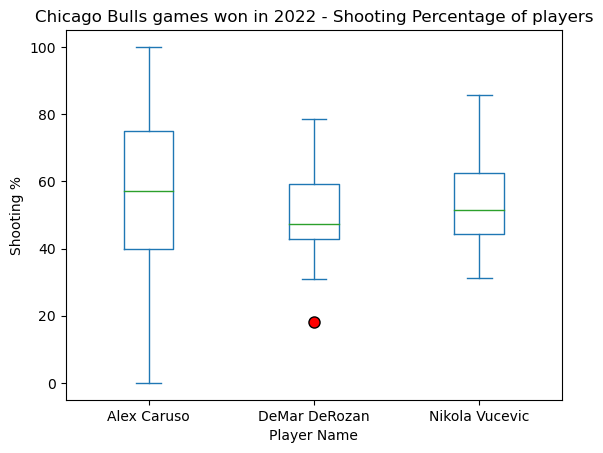

In [30]:
#Define dataframe
data = pd.DataFrame({"Alex Caruso": alex_win_stats['FG%'] * 100, "DeMar DeRozan": demar_win_stats['FG%'] * 100, "Nikola Vucevic": nikola_win_stats['FG%']* 100})
# Plot dataframe as box-and-whisker plot
ax = data[['Alex Caruso', 'DeMar DeRozan', 'Nikola Vucevic']].plot(kind='box', title='Chicago Bulls games won in 2022 - Shooting Percentage of players', ylabel='Shooting %', xlabel='Player Name', flierprops={'markersize': 8, 'markerfacecolor': 'red'})

# Display the plot
plt.show()

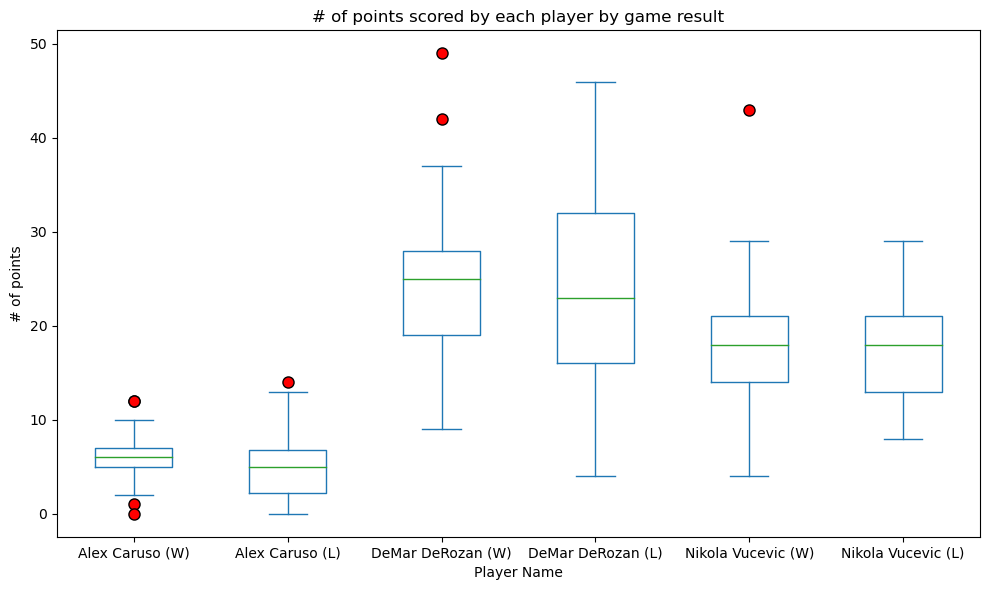

In [31]:
plt.rcParams["figure.autolayout"] = True
plt.rcParams["figure.figsize"] = [10, 6]
# Pandas dataframe
data = pd.DataFrame({"Alex Caruso (W)": alex_win_stats['PTS'], "Alex Caruso (L)": alex_loss_stats['PTS'], "DeMar DeRozan (W)": demar_win_stats['PTS'], "DeMar DeRozan (L)": demar_loss_stats['PTS'], "Nikola Vucevic (W)": nikola_win_stats['PTS'], "Nikola Vucevic (L)": nikola_loss_stats['PTS']})
# Plot the dataframe
ax = data[['Alex Caruso (W)', 'Alex Caruso (L)', 'DeMar DeRozan (W)','DeMar DeRozan (L)', 'Nikola Vucevic (W)', 'Nikola Vucevic (L)']].plot(kind='box', title='# of points scored by each player by game result', ylabel='# of points', xlabel='Player Name', flierprops={'markersize': 8, 'markerfacecolor': 'red'})
# Display the plot
plt.show()

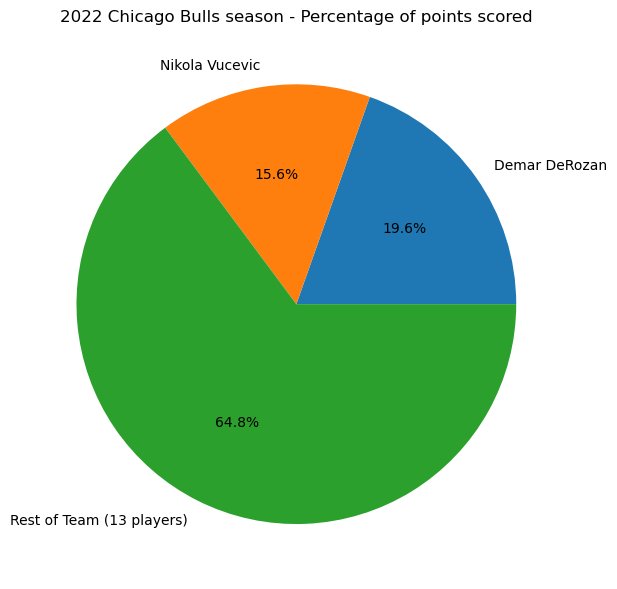

In [32]:
chicago_2022_data = nba_2022_data.loc[nba_2022_data['Team'] == 'Chicago Bulls']
chicago_total_points = chicago_2022_data['Tm'].sum()
chicago_total_points
demar_2022_total_points = demar_win_stats['PTS'].sum() + demar_loss_stats['PTS'].sum()
nikola_2022_total_points = nikola_win_stats['PTS'].sum() + nikola_loss_stats['PTS'].sum()
demar_2022_points_pct = demar_2022_total_points / chicago_total_points
nikola_2022_points_pct = nikola_2022_total_points / chicago_total_points
rest_2022_points_pct = (chicago_total_points - demar_2022_total_points - nikola_2022_total_points) / chicago_total_points
point_pct = np.array([demar_2022_points_pct, nikola_2022_points_pct, rest_2022_points_pct])
point_labels = np.array(['Demar DeRozan', 'Nikola Vucevic', 'Rest of Team (13 players)'])

plt.pie(point_pct, labels = point_labels, autopct = '%1.1f%%')
plt.title('2022 Chicago Bulls season - Percentage of points scored')
plt.savefig("./outputs/2022_bulls_percent_of_points_scored.png")

In [33]:
nikola_points_per_game = nikola_stats_analysis.copy()
nikola_points_per_game = nikola_points_per_game.loc[(nikola_points_per_game['PTS'] != 'Inactive') & (nikola_points_per_game['PTS'] != 'Did Not Dress')]
nikola_points_per_game['Nikola Vucevic Points'] = nikola_points_per_game['PTS']
demar_points_per_game = demar_stats_analysis.copy()
demar_points_per_game = demar_points_per_game.loc[(demar_points_per_game['PTS'] != 'Inactive') & (demar_points_per_game['PTS'] != 'Did Not Dress')]
demar_points_per_game['DeMar DeRozan Points'] = demar_points_per_game['PTS']
chicago_2022_data
team_points_per_game = pd.merge(chicago_2022_data, nikola_points_per_game, how = 'inner', left_on=["Year", "Game"], right_on=["Year", "Game"])
team_points_per_game = pd.merge(team_points_per_game, demar_points_per_game, how = 'inner', left_on=["Year", "Game"], right_on=["Year", "Game"])
team_points_per_game['Nikola Vucevic Points'] = team_points_per_game['Nikola Vucevic Points'].astype(int)
team_points_per_game['DeMar DeRozan Points'] = team_points_per_game['DeMar DeRozan Points'].astype(int)
team_points_per_game['Rest of Team'] = team_points_per_game['Tm'] - (team_points_per_game['Nikola Vucevic Points'] + team_points_per_game['DeMar DeRozan Points'])
team_points_per_game[['Team', 'Game', 'Tm', 'Nikola Vucevic Points', 'DeMar DeRozan Points', 'Rest of Team']].sort_values(by=['Game'])


,Team,Game,Tm,Nikola Vucevic Points,DeMar DeRozan Points,Rest of Team
0,Chicago Bulls,1,116,15,37,64
2,Chicago Bulls,2,100,24,32,44
3,Chicago Bulls,3,96,16,13,67
4,Chicago Bulls,4,120,18,25,77
5,Chicago Bulls,5,124,14,17,93
...,...,...,...,...,...,...
68,Chicago Bulls,77,121,21,23,77
38,Chicago Bulls,78,128,13,31,84
39,Chicago Bulls,79,105,19,21,65
50,Chicago Bulls,80,92,21,8,63


Text(18, 10, 'y = 0.94x + 13.18')

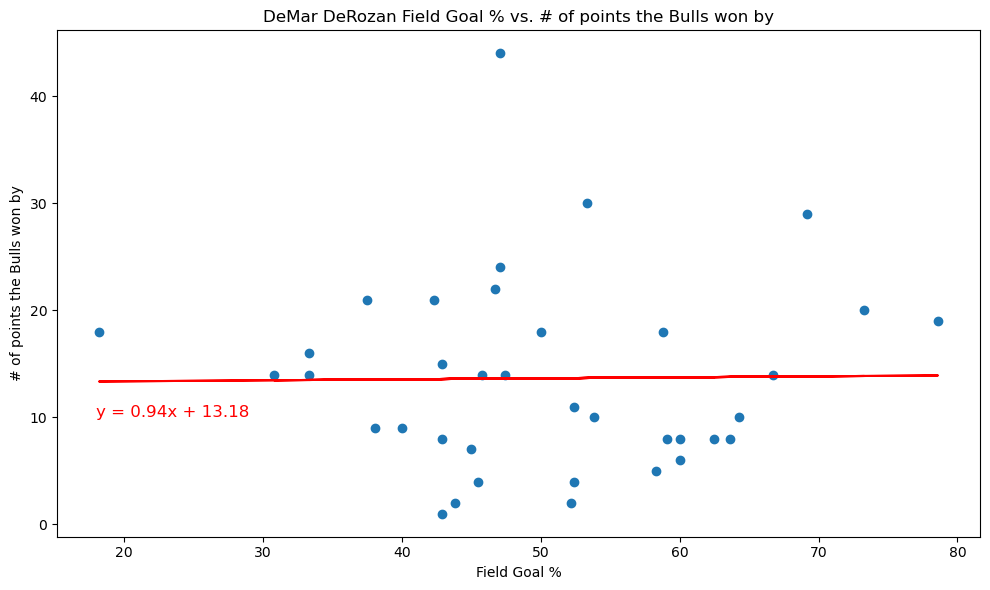

In [34]:
import scipy.stats as st
import matplotlib.ticker as ticker
from scipy.stats import linregress

#Calculate correlation coefficient
correlation = st.pearsonr(demar_win_stats['FG%'], demar_win_stats['Score difference'])
(slope, intercept, rvalue, pvalue, stderr) = linregress(demar_win_stats['FG%'], demar_win_stats['Score difference'])
#Calculate regression line
regress_values = demar_win_stats['FG%'] * slope + intercept
#Create line equation
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(demar_win_stats['FG%']*100, demar_win_stats['Score difference'])
#Add regression line to scatter plot and format line
plt.plot(demar_win_stats['FG%']*100,regress_values,color="red")
plt.xlabel('Field Goal %')
plt.ylabel('# of points the Bulls won by')
plt.title("DeMar DeRozan Field Goal % vs. # of points the Bulls won by")
plt.annotate(line_eq,(18,10),fontsize=12,color="red")

In [35]:
demar_no_play = demar_stats_2022.loc[((demar_stats_2022['GS'] == 'Inactive') | \
                                      (demar_stats_2022['GS'] == 'Did Not Play'))]
demar_no_play = demar_no_play[['Year', 'Game', 'Team', 'Opponent', 'Result', 'Tm', 'Opp', 'Player', 'GS']]
demar_no_play['Score Difference'] = abs(demar_no_play['Tm'] - demar_no_play['Opp'])
demar_no_play

,Year,Game,Team,Opponent,Result,Tm,Opp,Player,GS,Score Difference
12,2022,42,Chicago Bulls,Washington Wizards,L,97,100,DeMar DeRozan,Inactive,3
78,2022,43,Chicago Bulls,Oklahoma City Thunder,L,110,124,DeMar DeRozan,Inactive,14
81,2022,44,Chicago Bulls,Golden State Warriors,W,132,118,DeMar DeRozan,Inactive,14
102,2022,59,Chicago Bulls,Milwaukee Bucks,L,100,112,DeMar DeRozan,Inactive,12
294,2022,58,Chicago Bulls,Indiana Pacers,L,113,117,DeMar DeRozan,Inactive,4
315,2022,54,Chicago Bulls,Memphis Grizzlies,L,89,104,DeMar DeRozan,Inactive,15
339,2022,73,Chicago Bulls,Portland Trail Blazers,W,124,96,DeMar DeRozan,Inactive,28
483,2022,81,Chicago Bulls,Dallas Mavericks,W,115,112,DeMar DeRozan,Inactive,3


In [36]:
demar_no_play_win = demar_no_play.loc[demar_no_play['Result'] == 'W']
demar_no_play_loss = demar_no_play.loc[demar_no_play['Result'] == 'L']
demar_no_play_win_avg_diff = demar_no_play_win['Score Difference'].mean()
demar_no_play_loss_avg_diff = demar_no_play_loss['Score Difference'].mean()
demar_no_play_avg_score = demar_no_play['Tm'].mean()

print(demar_no_play_win_avg_diff, demar_no_play_loss_avg_diff, demar_no_play_avg_score)

15.0 9.6 110.0


In [37]:
demar_games_played = demar_stats_2022.loc[(demar_stats_2022['GS'] != 'Inactive') & (demar_stats_2022['GS'] != 'Did Not Dress')]
demar_games_played = demar_games_played[['Year', 'Game', 'Team', 'Opponent', 'Result', 'Tm', 'Opp', 'Player', 'GS', 'PTS']]
demar_games_played['PTS'] = demar_games_played['PTS'].astype(int)
demar_games_played['Score Difference'] = abs(demar_games_played['Tm'] - demar_games_played['Opp'])
demar_games_played_win = demar_games_played.loc[demar_games_played['Result'] == 'W']
demar_games_played_loss = demar_games_played.loc[demar_games_played['Result'] == 'L']
demar_games_played_win_avg_diff = demar_games_played_win['Score Difference'].mean()
demar_games_played_loss_avg_diff = demar_games_played_loss['Score Difference'].mean()
demar_games_played_avg_score = demar_games_played['Tm'].mean()

print(demar_games_played_win_avg_diff, demar_games_played_loss_avg_diff, demar_games_played_avg_score)


13.64864864864865 10.702702702702704 113.45945945945945


Text(0, 0.5, '# of games the Bulls won')

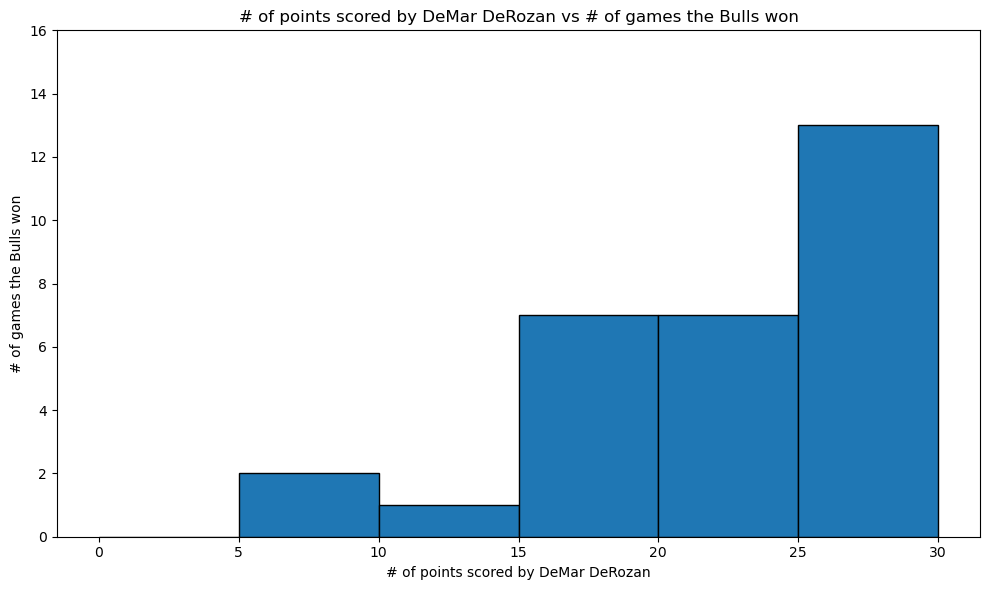

In [38]:
bins = [0,5,10,15,20,25,30]

plt.hist(demar_games_played_win['PTS'], bins, histtype='bar', rwidth=1, edgecolor = "black")
plt.yticks(np.arange(0, 18, 2))
plt.title('# of points scored by DeMar DeRozan vs # of games the Bulls won')
plt.xlabel('# of points scored by DeMar DeRozan')
plt.ylabel('# of games the Bulls won')

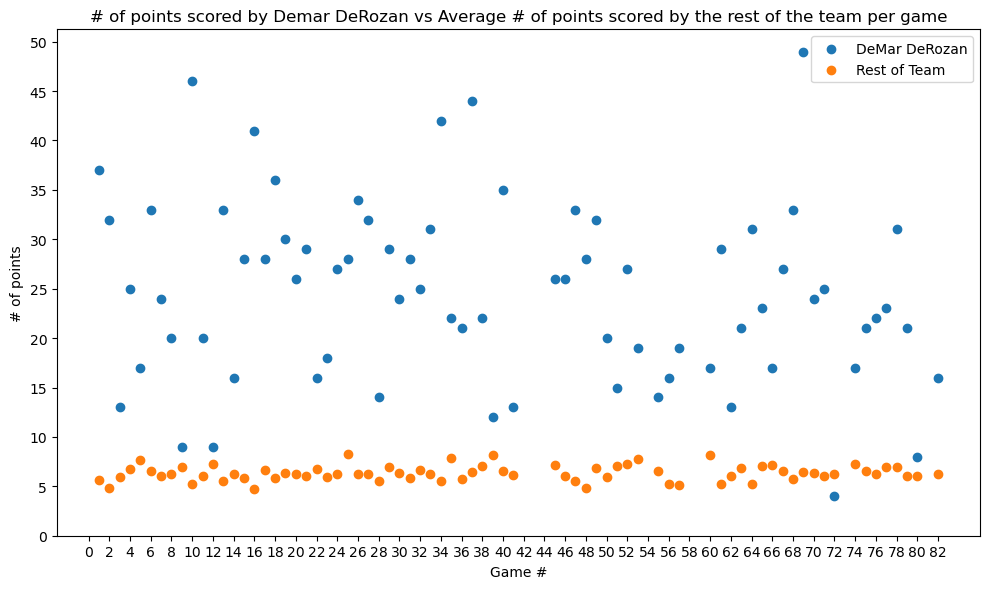

In [39]:
number_of_bulls_players = 15
demar_pts_per_game = demar_games_played[['Game', 'Result', 'Tm', 'PTS']]
demar_pts_per_game['Avg pts per player'] = (demar_pts_per_game['Tm'] - demar_pts_per_game['PTS']) \
    / ((number_of_bulls_players) - 1)
demar_pts_per_game
plt.scatter(demar_pts_per_game['Game'], demar_pts_per_game['PTS'])
plt.scatter(demar_pts_per_game['Game'], demar_pts_per_game['Avg pts per player'])
plt.xticks(np.arange(0, 84, 2))
plt.yticks(np.arange(0, 55, 5))
plt.title('# of points scored by Demar DeRozan vs Average # of points scored by the rest of the team per game')
plt.xlabel('Game #')
plt.ylabel('# of points')
plt.legend(["DeMar DeRozan" , "Rest of Team"])
plt.savefig("./outputs/2022_demar_vs_rest_of_team_points.png")
plt.show()
#plt.xlabel('Field Goal %')
#plt.ylabel('# of points the Bulls won by')
#plt.title('DeMar DeRozan Field Goal % vs. # of points the Bulls won by')



In [40]:
nikola_games_played = nikola_stats_2022.loc[(nikola_stats_2022['GS'] != 'Inactive') & (nikola_stats_2022['GS'] != 'Did Not Dress')]
nikola_games_played = nikola_games_played[['Year', 'Game', 'Team', 'Opponent', 'Result', 'Tm', 'Opp', \
     'Player', 'GS', 'TRB']]
nikola_games_played['TRB'] = nikola_games_played['TRB'].astype(float)
nikola_games_played['Score Difference'] = abs(nikola_games_played['Tm'] - nikola_games_played['Opp'])
nikola_games_played_win = nikola_games_played.loc[nikola_games_played['Result'] == 'W']
nikola_games_played_loss = nikola_games_played.loc[nikola_games_played['Result'] == 'L']
nikola_games_played_win_avg_diff = nikola_games_played_win['Score Difference'].mean()
nikola_games_played_loss_avg_diff = nikola_games_played_loss['Score Difference'].mean()
nikola_games_played_avg_score = nikola_games_played['Tm'].mean()


Text(18, 10, 'y = 0.08x + 12.76')

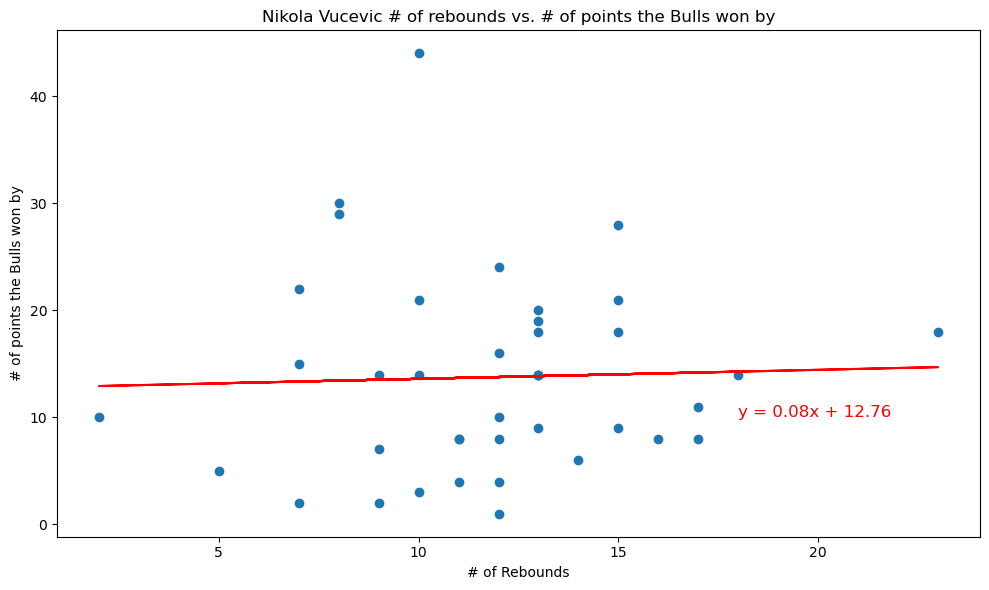

In [41]:
import scipy.stats as st
import matplotlib.ticker as ticker
from scipy.stats import linregress

#Calculate correlation coefficient
correlation = st.pearsonr(nikola_games_played_win['TRB'], nikola_games_played_win['Score Difference'])
(slope, intercept, rvalue, pvalue, stderr) = linregress(nikola_games_played_win['TRB'], nikola_games_played_win['Score Difference'])
#Calculate regression line
regress_values = nikola_games_played_win['TRB'] * slope + intercept
#Create line equation
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(nikola_games_played_win['TRB'], nikola_games_played_win['Score Difference'])
#Add regression line to scatter plot and format line
plt.plot(nikola_games_played_win['TRB'],regress_values,color="red")
plt.xlabel('# of Rebounds')
plt.ylabel('# of points the Bulls won by')
plt.title('Nikola Vucevic # of rebounds vs. # of points the Bulls won by')
plt.annotate(line_eq,(18,10),fontsize=12,color="red")

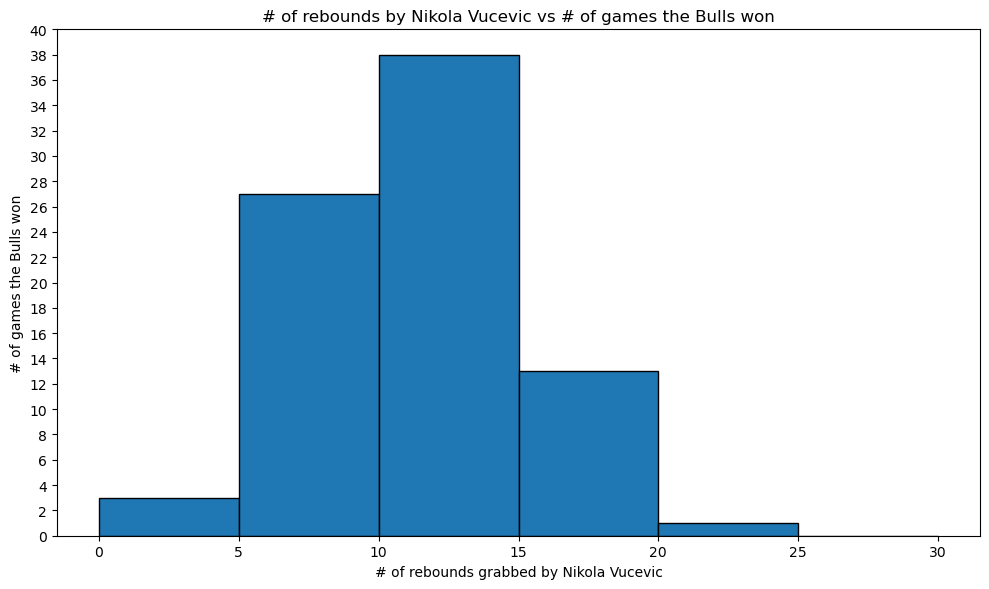

In [42]:
bins = [0,5,10,15,20,25,30]

plt.hist(nikola_games_played['TRB'], bins, histtype='bar', rwidth=1, edgecolor = "black")
plt.yticks(np.arange(0, 42, 2))
plt.title('# of rebounds by Nikola Vucevic vs # of games the Bulls won')
plt.xlabel('# of rebounds grabbed by Nikola Vucevic')
plt.ylabel('# of games the Bulls won')
plt.savefig("./outputs/2022_vucevic_rebounds_vs_games_won.png")

In [43]:
lakers_player_stats_columns = ['Year','Game', 'Opponent', 'Result', \
'Player', 'FGA', 'FG', 'FG%', 'Tm', 'Opp', 'PTS', 'TRB']
lebron_stats_2022 = final_player_stats.loc[final_player_stats['Player'] == 'LeBron James']
lebron_stats_analysis = lebron_stats_2022[(lakers_player_stats_columns)]
lebron_stats_analysis['Score difference'] = lebron_stats_2022['Tm'] - lebron_stats_2022['Opp']
lebron_stats_analysis
lebron_win_stats = lebron_stats_analysis.loc[(lebron_stats_analysis['Result'] == 'W') \
& (lebron_stats_analysis['FGA'] != 'Inactive') & (lebron_stats_analysis['FGA'] != 'Did Not Dress')]
lebron_win_stats['FG%'] = lebron_win_stats['FG%'].astype(float)
lebron_win_stats['PTS'] = lebron_win_stats['PTS'].astype(int)
lebron_loss_stats = lebron_stats_analysis.loc[(lebron_stats_analysis['Result'] == 'L') \
& (lebron_stats_analysis['FGA'] != 'Inactive') & (lebron_stats_analysis['FGA'] != 'Did Not Dress')]
lebron_loss_stats['FG%'] = lebron_loss_stats['FG%'].astype(float)
lebron_loss_stats['PTS'] = lebron_loss_stats['PTS'].astype(int)
davis_stats_2022 = final_player_stats.loc[final_player_stats['Player'] == 'Anthony Davis']
davis_stats_analysis = davis_stats_2022[(lakers_player_stats_columns)]
davis_stats_analysis['Score difference'] = davis_stats_2022['Tm'] - davis_stats_2022['Opp']
davis_stats_analysis
davis_win_stats = davis_stats_analysis.loc[(davis_stats_analysis['Result'] == 'W') \
& (davis_stats_analysis['FGA'] != 'Inactive') & (davis_stats_analysis['FGA'] != 'Did Not Dress')]
davis_win_stats['FG%'] = davis_win_stats['FG%'].astype(float)
davis_win_stats['PTS'] = davis_win_stats['PTS'].astype(int)
davis_loss_stats = davis_stats_analysis.loc[(davis_stats_analysis['Result'] == 'L') \
& (davis_stats_analysis['FGA'] != 'Inactive') & (davis_stats_analysis['FGA'] != 'Did Not Dress')]
davis_loss_stats['FG%'] = davis_loss_stats['FG%'].astype(float)
davis_loss_stats['PTS'] = davis_loss_stats['PTS'].astype(int)

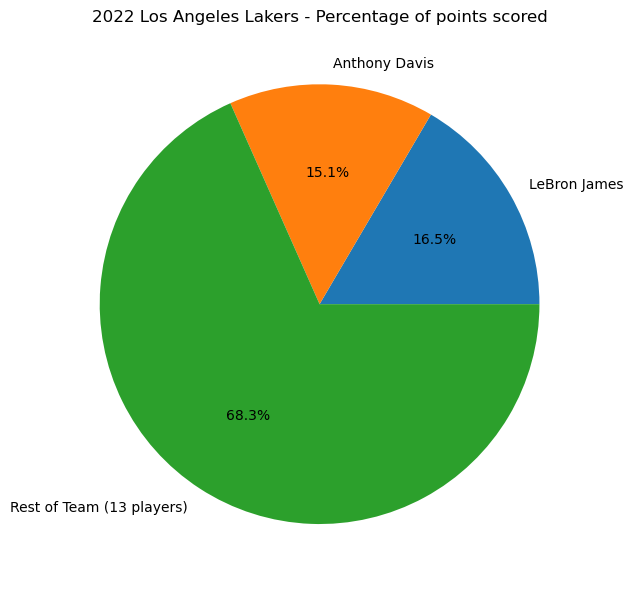

In [44]:
lakers_2022_data = nba_2022_data.loc[nba_2022_data['Team'] == 'Los Angeles Lakers']
lakers_total_points = lakers_2022_data['Tm'].sum()
lakers_total_points
LeBron_2022_total_points = lebron_win_stats['PTS'].sum() + lebron_loss_stats['PTS'].sum()
Davis_2022_total_points = davis_win_stats['PTS'].sum() + davis_loss_stats['PTS'].sum()
Lebron_2022_points_pct = LeBron_2022_total_points / lakers_total_points
Davis_2022_points_pct = Davis_2022_total_points / lakers_total_points
rest_2022_points_pct = (lakers_total_points - LeBron_2022_total_points - Davis_2022_total_points) / lakers_total_points
point_pct = np.array([Lebron_2022_points_pct, Davis_2022_points_pct, rest_2022_points_pct])
point_labels = np.array(['LeBron James', 'Anthony Davis', 'Rest of Team (13 players)'])
plt.pie(point_pct, labels = point_labels, autopct = '%1.1f%%')
plt.title('2022 Los Angeles Lakers - Percentage of points scored')
plt.savefig("./outputs/2022_lakers_percent_of_points_scored.png")

In [45]:
lebron_games_played = lebron_stats_2022.loc[(lebron_stats_2022['GS'] != 'Inactive') & (lebron_stats_2022['GS'] != 'Did Not Dress')]
lebron_games_played = lebron_games_played[['Year', 'Game', 'Team', 'Opponent', 'Result', 'Tm', 'Opp', 'Player', 'GS', 'PTS']]
lebron_games_played['PTS'] = lebron_games_played['PTS'].astype(int)
lebron_games_played['Score Difference'] = abs(lebron_games_played['Tm'] - lebron_games_played['Opp'])
lebron_games_played_win = lebron_games_played.loc[lebron_games_played['Result'] == 'W']
lebron_games_played_loss = lebron_games_played.loc[lebron_games_played['Result'] == 'L']
lebron_games_played_win_avg_diff = lebron_games_played_win['Score Difference'].mean()
lebron_games_played_loss_avg_diff = lebron_games_played_loss['Score Difference'].mean()
lebron_games_played_avg_score = lebron_games_played['Tm'].mean()
print(lebron_games_played_win_avg_diff, lebron_games_played_loss_avg_diff, lebron_games_played_avg_score)

9.533333333333333 8.44 119.14545454545454


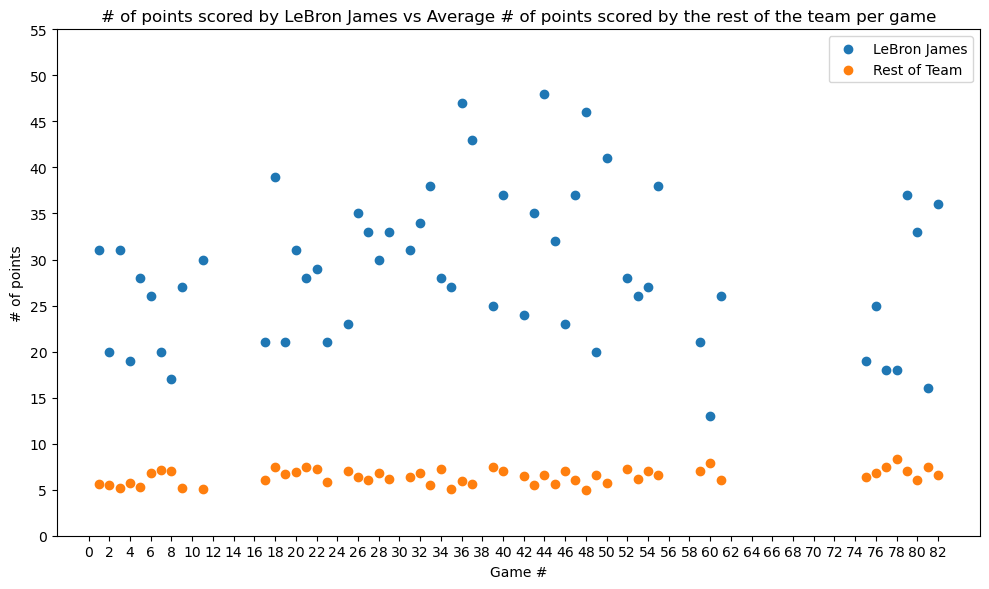

In [46]:
number_of_lakers_players = 15
lebron_pts_per_game = lebron_games_played[['Game', 'Result', 'Tm', 'PTS']]
lebron_pts_per_game['Avg pts per player'] = (lebron_pts_per_game['Tm'] - lebron_pts_per_game['PTS']) \
    / ((number_of_lakers_players) - 1)
lebron_pts_per_game
plt.scatter(lebron_pts_per_game['Game'], lebron_pts_per_game['PTS'])
plt.scatter(lebron_pts_per_game['Game'], lebron_pts_per_game['Avg pts per player'])
plt.xticks(np.arange(0, 84, 2))
plt.yticks(np.arange(0, 60, 5))
plt.title('# of points scored by LeBron James vs Average # of points scored by the rest of the team per game')
plt.xlabel('Game #')
plt.ylabel('# of points')
plt.legend(["LeBron James" , "Rest of Team"])
plt.savefig("./outputs/2022_lebron_vs_rest_of_team_points.png")
plt.show()
#plt.xlabel('Field Goal %')
#plt.ylabel('# of points the Bulls won by')
#plt.title('DeMar DeRozan Field Goal % vs. # of points the Bulls won by')

In [47]:
davis_games_played = davis_stats_2022.loc[(davis_stats_2022['GS'] != 'Inactive') & (davis_stats_2022['GS'] != 'Did Not Dress')]
davis_games_played = davis_games_played[['Year', 'Game', 'Team', 'Opponent', 'Result', 'Tm', 'Opp', 'Player', 'GS', 'PTS', 'TRB']]
davis_games_played['PTS'] = davis_games_played['PTS'].astype(int)
davis_games_played['Score Difference'] = abs(davis_games_played['Tm'] - davis_games_played['Opp'])
davis_games_played_win = davis_games_played.loc[davis_games_played['Result'] == 'W']
davis_games_played_loss = davis_games_played.loc[davis_games_played['Result'] == 'L']
davis_games_played_win_avg_diff = davis_games_played_win['Score Difference'].mean()
davis_games_played_loss_avg_diff = davis_games_played_loss['Score Difference'].mean()
davis_games_played_avg_score = davis_games_played['Tm'].mean()
print(davis_games_played_win_avg_diff, davis_games_played_loss_avg_diff, davis_games_played_avg_score)

10.64516129032258 8.72 116.5


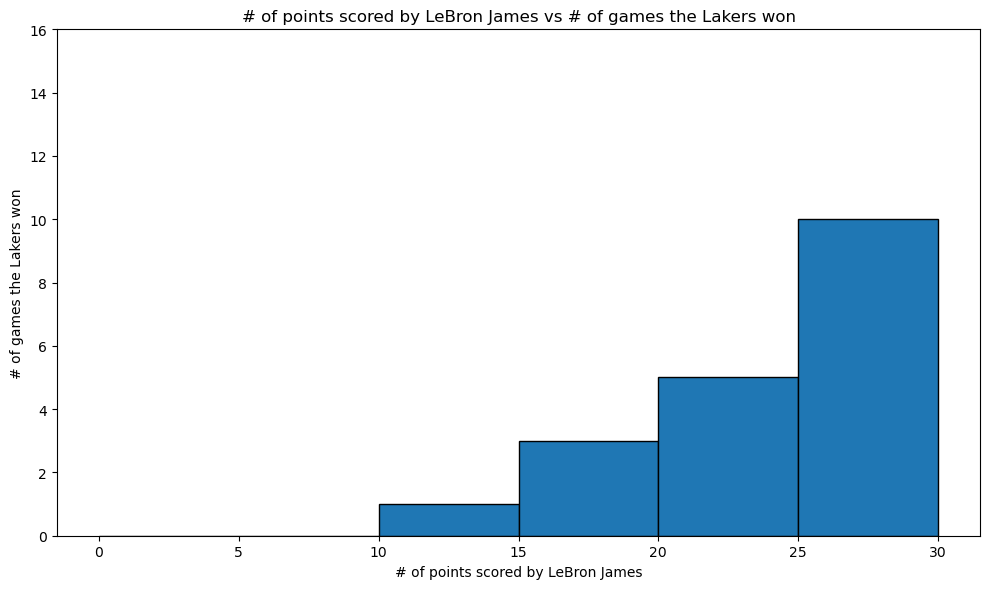

In [48]:
bins = [0,5,10,15,20,25,30]

plt.hist(lebron_games_played_win['PTS'], bins, histtype='bar', rwidth=1, edgecolor = "black")
plt.yticks(np.arange(0, 18, 2))
plt.title('# of points scored by LeBron James vs # of games the Lakers won')
plt.xlabel('# of points scored by LeBron James')
plt.ylabel('# of games the Lakers won')
plt.savefig("./outputs/2022_lebron_points_vs_games_won.png")